KAGGLE CONF

In [1]:
from google.colab import files
!pip install -q kaggle

In [2]:
#upload api key
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d jsphyg/weather-dataset-rattle-package
! unzip weather-dataset-rattle-package.zip 

  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 63.7MB/s]
Archive:  weather-dataset-rattle-package.zip
  inflating: weatherAUS.csv          


In [111]:
#ALL IMPORT 
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

DATA USED

In [112]:
df = pd.read_csv("weatherAUS.csv")
df = df [:12000]
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2017-04-15,CoffsHarbour,12.8,24.5,2.4,NaN,NaN,E,20.0,NW,E,9.0,15.0,69.0,62.0,1020.9,1018.1,NaN,NaN,22.1,23.4,Yes,No
11996,2017-04-16,CoffsHarbour,12.3,25.9,0.0,NaN,NaN,NE,31.0,NW,NE,9.0,24.0,70.0,62.0,1020.7,1017.7,NaN,NaN,21.4,24.2,No,No
11997,2017-04-17,CoffsHarbour,14.7,24.4,0.0,NaN,NaN,SSE,28.0,SW,SE,13.0,11.0,64.0,61.0,1023.3,1021.0,NaN,NaN,22.2,23.4,No,No
11998,2017-04-18,CoffsHarbour,14.6,24.7,0.0,NaN,NaN,SSE,30.0,WSW,SSE,15.0,20.0,70.0,58.0,1026.2,1023.9,NaN,NaN,21.8,24.0,No,Yes


In [113]:
print("DATA YANG DIGUNAKAN: ",len(df))

DATA YANG DIGUNAKAN:  12000


In [114]:
df.isnull().sum()

Date                0
Location            0
MinTemp            68
MaxTemp            61
Rainfall          187
Evaporation      7549
Sunshine         9956
WindGustDir       509
WindGustSpeed     509
WindDir9am       1334
WindDir3pm        449
WindSpeed9am      371
WindSpeed3pm      366
Humidity9am       207
Humidity3pm       210
Pressure9am       514
Pressure3pm       519
Cloud9am         5923
Cloud3pm         5681
Temp9am            73
Temp3pm            73
RainToday         187
RainTomorrow      187
dtype: int64

In [115]:
#drop kolom yang tidak digunakan
data = df.filter(['Date','MaxTemp'], axis=1)
data

,Date,MaxTemp
0,2008-12-01,22.9
1,2008-12-02,25.1
2,2008-12-03,25.7
3,2008-12-04,28.0
4,2008-12-05,32.3
...,...,...
11995,2017-04-15,24.5
11996,2017-04-16,25.9
11997,2017-04-17,24.4
11998,2017-04-18,24.7


In [116]:
data.isnull().sum()

Date        0
MaxTemp    61
dtype: int64

In [117]:
mean_maxtemp = round(data['MaxTemp'].mean(),1)
#isi yang kosong dengan rata-rata
values = {'MaxTemp':mean_maxtemp}
data = data.fillna(value=values)
data.isnull().sum()

Date       0
MaxTemp    0
dtype: int64

In [118]:
data

,Date,MaxTemp
0,2008-12-01,22.9
1,2008-12-02,25.1
2,2008-12-03,25.7
3,2008-12-04,28.0
4,2008-12-05,32.3
...,...,...
11995,2017-04-15,24.5
11996,2017-04-16,25.9
11997,2017-04-17,24.4
11998,2017-04-18,24.7


In [119]:
#10% dari data
max = df['MaxTemp'].max()
print('Max value: ',max)
min = df['MaxTemp'].min()
print('Min value: ',min)
result = (max-min) * (10/100)
print(result)

Max value:  46.6
Min value:  6.8
3.9800000000000004


Text(0.5, 1.0, 'Temperature Average')

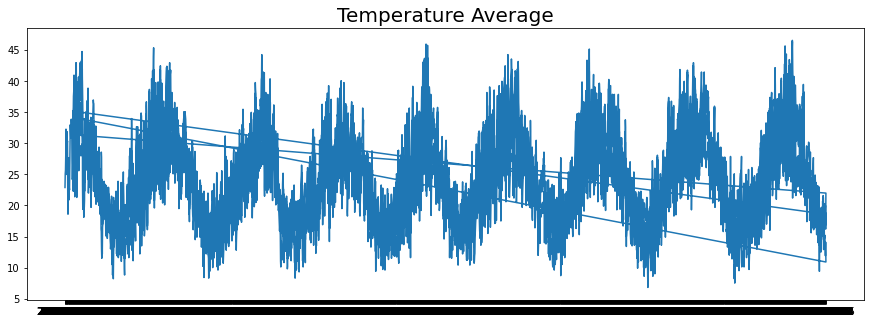

In [120]:
dates = data['Date'].values
max_temp = data['MaxTemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates,max_temp)
plt.title("Temperature Average", fontsize=20)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(dates,max_temp, test_size=0.2, shuffle = False )

In [122]:
def windowed_dataset(series, window_size, batch_size,shuffle_buffer):
  series = tf.expand_dims(series,axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [126]:
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(y_train, window_size=64, batch_size=200, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=64, batch_size=200, shuffle_buffer=1000)


In [145]:
model = tf.keras.models.Sequential([
                                   tf.keras.layers.LSTM(60, return_sequences=True),
                                   tf.keras.layers.LSTM(60),
                                   tf.keras.layers.Dense(30, activation='relu'),
                                   tf.keras.layers.Dense(10, activation='relu'),
                                   tf.keras.layers.Dense(1)
                                   
])

In [146]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < result and logs.get('val_mae') < result):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [147]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss= tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, 
                    epochs=100,
                    batch_size=64,
                    validation_data = test_set, 
                    callbacks=[callbacks]
                    )

Epoch 1/100
48/48 [==============================] - 28s 495ms/step - loss: 23.5111 - mae: 24.0111 - val_loss: 23.3113 - val_mae: 23.8113
Epoch 2/100
48/48 [==============================] - 23s 476ms/step - loss: 23.2950 - mae: 23.7950 - val_loss: 23.1313 - val_mae: 23.6313
Epoch 3/100
48/48 [==============================] - 23s 477ms/step - loss: 23.0975 - mae: 23.5975 - val_loss: 22.9079 - val_mae: 23.4079
Epoch 4/100
48/48 [==============================] - 23s 476ms/step - loss: 22.8434 - mae: 23.3434 - val_loss: 22.6105 - val_mae: 23.1105
Epoch 5/100
48/48 [==============================] - 23s 481ms/step - loss: 22.4882 - mae: 22.9882 - val_loss: 22.1761 - val_mae: 22.6761
Epoch 6/100
48/48 [==============================] - 23s 480ms/step - loss: 21.9452 - mae: 22.4452 - val_loss: 21.4844 - val_mae: 21.9844
Epoch 7/100
48/48 [==============================] - 23s 479ms/step - loss: 21.0366 - mae: 21.5366 - val_loss: 20.2697 - val_mae: 20.7697
Epoch 8/100
48/48 [===============

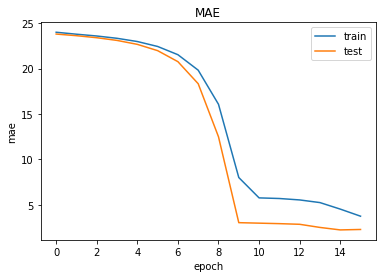

In [150]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

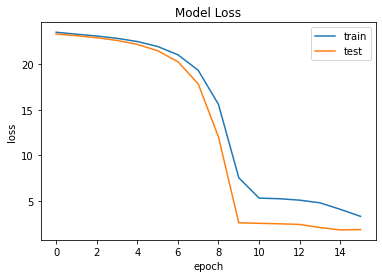

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()